In [17]:
%load_ext autoreload
%autoreload 2
# import torch; torch.manual_seed(955)
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from dataGen import Gen, FastGen, Gen2
from Encoders import LongShort_TCVAE_Encoder, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
from utils import * #train_on_effect, generate_data, extract_parameters, suppress_prints, add_mu_std
from train import *
import argparse
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import pprint
torch.set_printoptions(sci_mode=False)

# all parameters for generating the time series should be configured in this cell
        
p=2       
args = GENV(n_channels=2,
            latent_dims=5,
            n_samples=50,
            shuffle=False,
            periode=p,
            L=288*p,
            min_max=False,
            num_layers=3,
            ß=10,
            modified=False,
            first_kernel=288)
effects = {
    "Pulse": {
        "occurances":1,
        "max_amplitude":5,   
        "interval":40,
        "start":None
        },
    "Trend": {
        "occurances":10,
        "max_slope":0.002,
        "type":"linear",
        "start":None
        },
    "Seasonality": {
        "occurances":10,
        "frequency_per_week":(7, 14), # min and max occurances per week
        "amplitude_range":(5, 20),
        "start":-5
        },
    "std_variation": {
        "occurances":0,
        "max_value":10,
        "interval":30,
        "start":None
        },
    "channels_coupling":{
        "occurances":0,
        "coupling_strengh":20
        },
    "Noise": {
        "occurances":0,
        "max_slope":0.005,
        "type":"linear"
        }
    }

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from importlib import reload
from Encoders import LongShort_TCVAE_Encoder#, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder#, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
args.num_embed = 512 # args.enc_out**2 
args.robust = False
vae = Variational_Autoencoder(args,
                            v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                            v_decoder = LongShort_TCVAE_Decoder #MST_VAE_Decoder,
                           )
vq = VQ_MST_VAE(args,
                v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                v_decoder = LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
                v_quantizer = VQ_Quantizer) #10 5

vae = vae.to(args.device)
vq = vq.to(args.device)

opt_vae = optim.Adam(vae.parameters(), lr = 0.002043529186448577) # 0.005043529186448577 0.006819850049647945
opt_vq = optim.Adam(vq.parameters(), lr = 0.002043529186448577) # 0.005043529186448577 0.006819850049647945

generating:  1
generating:  2
generating:  3
generating:  4
generating:  5
generating:  6
generating:  7
generating:  8
generating:  9


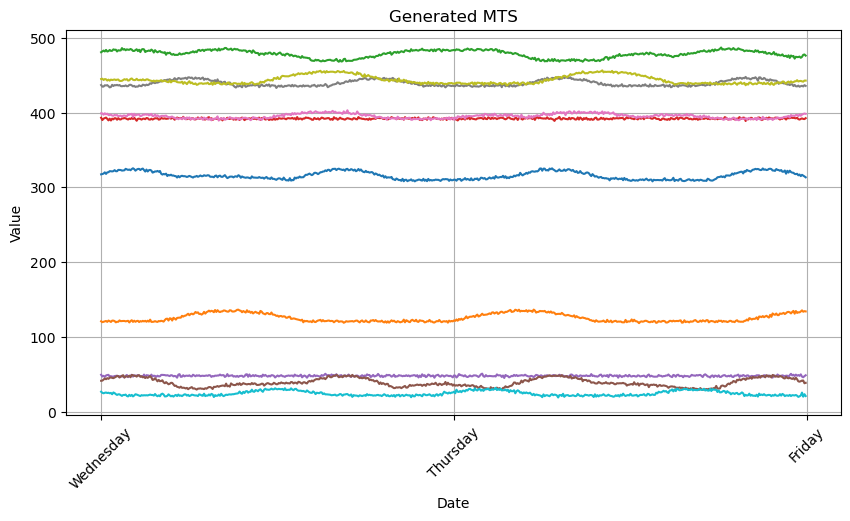

In [7]:
train_data, val_data, test_data, X = generate_labeled_data(args,
                                                           effects,
                                                           effect="Seasonality",
                                                           occurance=3,
                                                           return_gen=True,
                                                           anomalies=False)

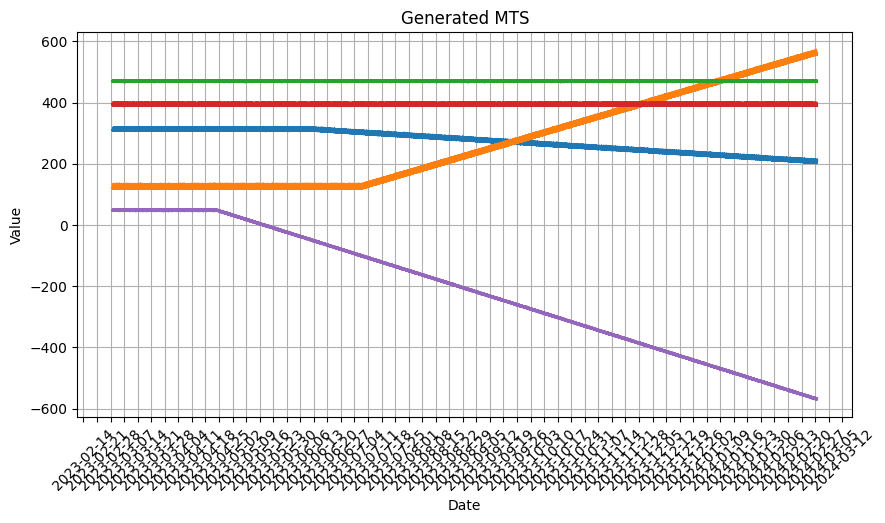

In [30]:
train_data_long, val_data_long, test_data_long, X_long = generate_long_data(args,
                                                                            effects,
                                                                            effect="both",
                                                                            occurance=3,
                                                                            return_gen=True,
                                                                            anomalies=False)

In [84]:
#Get actual frequencies per week and store them in numpy array
x_long, params_long, e_params_long = X_long.parameters()
frs_long = e_params_long["Seasonality"]["frequency_per_week"][0]
frs_long = np.array(frs_long)

# Get original and reconstructed TS both normalized for vae
Origin_norm_long, REC_norm_long, _ = rebuild_TS_non_overlapping(vae, train_data_long, args, keep_norm=True)
Origin_long, REC_long, _ = rebuild_TS_non_overlapping(vae, train_data_long, args, keep_norm=False)

# Denoise 
denoised_rec_long = denoise_data(REC_norm_long.T.cpu())
denoised_orig_long = denoise_data(Origin_norm_long.T.cpu())

# Generate new training loader with denoised data
train_data_long_denoised = DataLoader(StridedWindow(torch.from_numpy(denoised_orig_long), args),  # slidingWindow, stridedWindow
                            batch_size=args.bs,  # 59, # 22
                            shuffle=False,
                            drop_last=False
                            )

In [85]:
#Get actual frequencies per week and store them in numpy array
x, params, e_params = X.parameters()
frs = e_params["Seasonality"]["frequency_per_week"]
frs = np.array(frs)

# Get original and reconstructed TS both normalized and not for vae and VQ
Origin_vae_norm, REC_vae_norm, _ = rebuild_TS(vae, train_data, args, keep_norm=True)
Origin_vae, REC_vae, z = rebuild_TS(vae, train_data, args, keep_norm=False)

Origin_vq_norm, REC_vq_norm, _ = rebuild_TS(vq, train_data, args, keep_norm=True)
Origin_vq, REC_vq, indices = rebuild_TS(vq, train_data, args, keep_norm=False)

# Get the labels array for training data
labels = extract_parameters(args, e_params=e_params, effects=effects)
labels = add_mu_std(labels, params)
train_labels = labels[:Origin_vae_norm.shape[0]]
                      
# Denoise 
denoised_rec = denoise_data(REC_vae_norm.cpu())
denoised_orig = denoise_data(Origin_vae_norm.cpu())

# Generate new training loader with denoised data
train_data_denoised = DataLoader(NoWindow(torch.from_numpy(denoised_orig), args, train_labels, norm=True),  # slidingWindow, stridedWindow
                            batch_size=args.bs,  # 59, # 22
                            shuffle=False,
                            drop_last=False
                            )

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 3 but got size 6 for tensor number 1 in the list.

In [8]:
args.min_max= False
np.set_printoptions(suppress=True)
VAE_losses = []
VQ_losses = []

for epoch in range(1, 5000):
    loss_vae = train(vae, train_data_long, args, opt_vae, epoch)
    loss_vq = train(vq, train_data_long, args, opt_vq, epoch)
    
    if epoch%100 == 1:
        display.clear_output(wait=True)
        show_results_long(vae, train_data_long, args)
        show_results_long(vq, train_data_long, args, vq=True)
    if epoch%1000 == 1:
        plot_stats_results([vae, vq], train_data_long, args, long=True)
        print("VAE: \n")
        print_stats_results(vae, train_data_long, args, long=True)
        print("VQ: \n")
        print_stats_results(vq, train_data_long, args, long=True)
        
        
    VAE_losses.append(loss_vae)
    VQ_losses.append(loss_vq)
                
#     print('====> VAE: Sample {} Average loss: {:.4f}'.format(epoch, loss_vae / len(train_data_long.dataset)))
#     print('====> VQ: Sample {} Average loss: {:.4f}'.format(epoch, loss_vq / len(train_data_long.dataset)))

NameError: name 'train_data_long' is not defined

In [ ]:
# Your labels and corresponding values
labels = ['Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5']
values1 = [10, 15, 12, 8, 14]  # First set of values
values2 = [8, 12, 10, 6, 11]   # Second set of values

# Set the width of the bars
bar_width = 0.35

# Set the position of each label on the x-axis
x = np.arange(len(labels))

# Create the grouped bar chart
fig, ax = plt.subplots()
bar1 = ax.bar(x - bar_width/2, values1, bar_width, label='Value Set 1')
bar2 = ax.bar(x + bar_width/2, values2, bar_width, label='Value Set 2')

# Add labels, title, and legend
ax.set_xlabel('Labels')
ax.set_ylabel('Values')
ax.set_title('Comparison of Values for Each Label')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

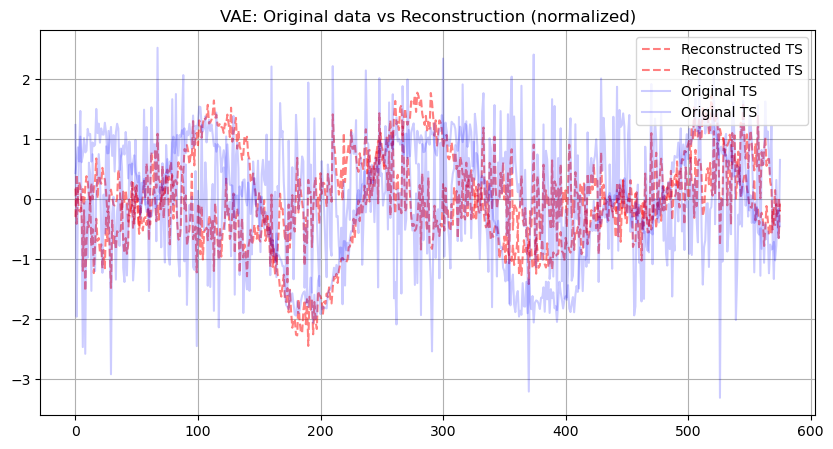

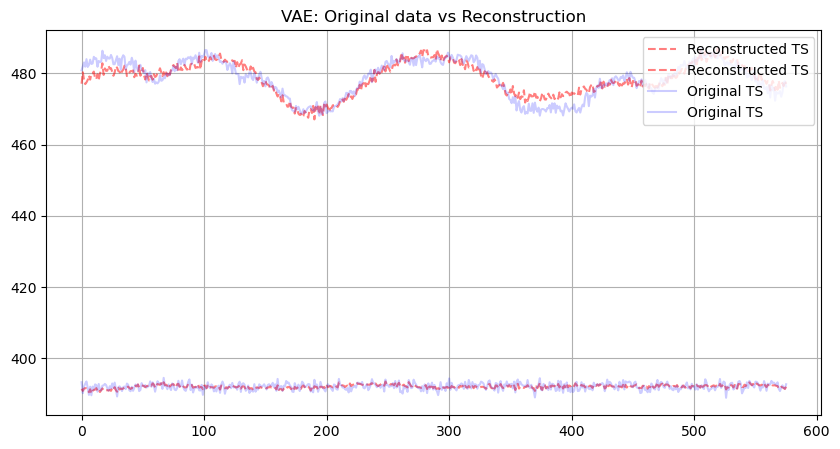

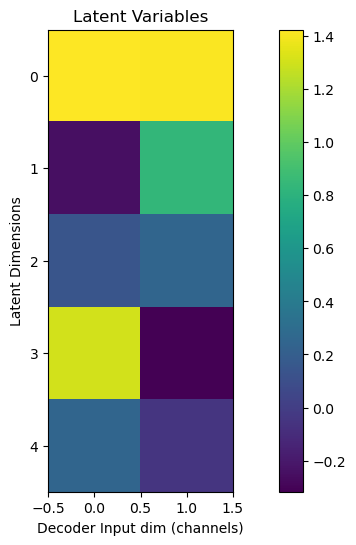

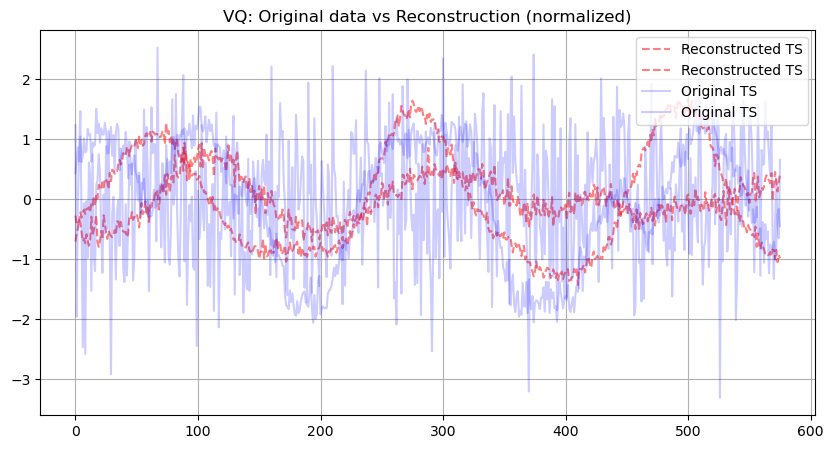

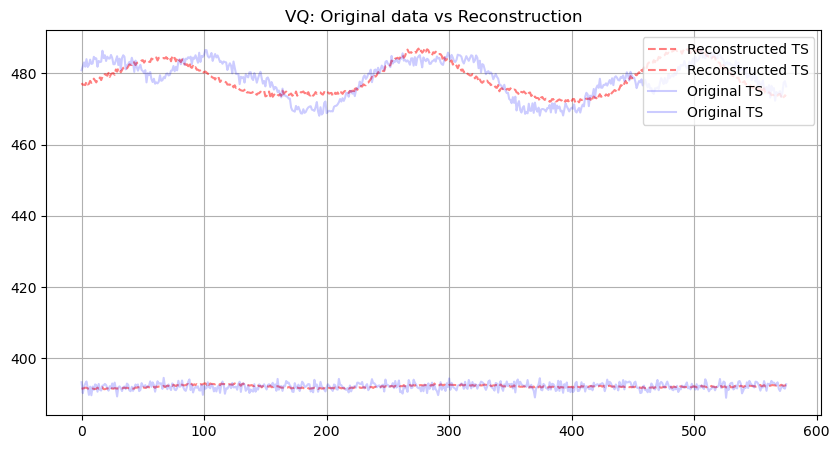

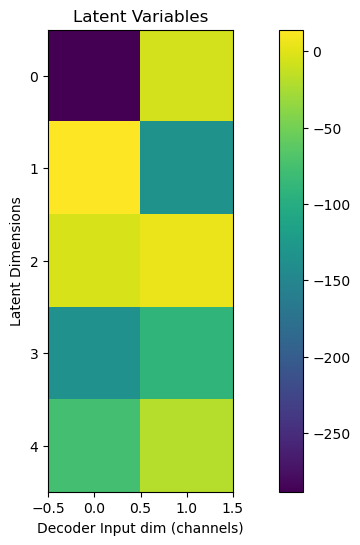

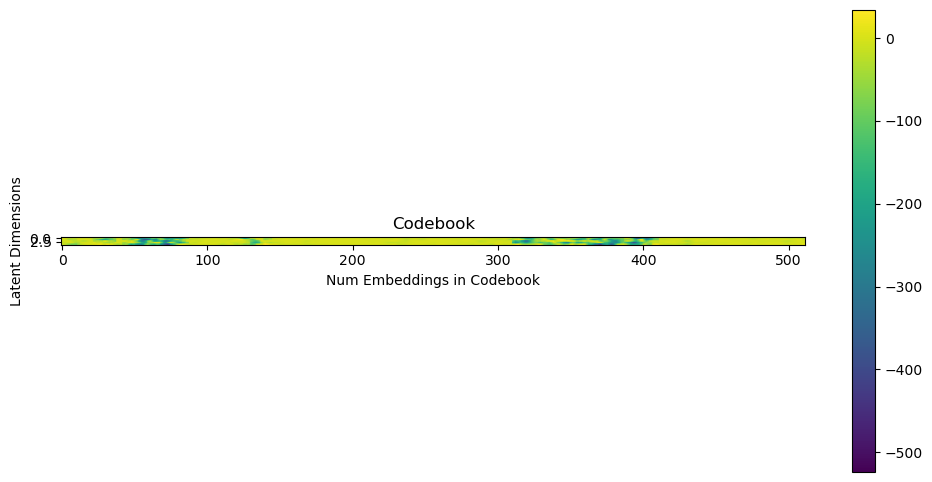

VAE: 

Mean global:  0.0033318514470010996
Std global:  0.4172426462173462
Max global:  2.066763401031494
Min global:  2.4892377853393555
Skew global:  0.03341818228363991
Kurt global:  0.0656304657459259


Mean window:  0.003676935564726591
Std window:  0.40947023034095764
Max Window:  1.9983458518981934
Min window: 2.4111897945404053
Skew window:  0.0299523938447237
Kurt window:  0.0566275529563427


VQ: 

Mean global:  0.003044246695935726
Std global:  3.911231756210327
Max global:  13.672410011291504
Min global:  8.172768592834473
Skew global:  0.1569637805223465
Kurt global:  0.2224748730659485


Mean window:  0.003462387016043067
Std window:  3.9213976860046387
Max Window:  14.142696380615234
Min window: 7.833406448364258
Skew window:  0.16683289408683777
Kurt window:  0.21561941504478455


====> VAE: Sample 151 Average loss: 1.0510
====> VQ: Sample 151 Average loss: 2.0542
Train Epoch: 152 [0/2 (0%)]	Loss: 420.209961	 True Loss: 107573.750000
Train Epoch: 152 [0/2 (0%)]	Loss: 79

Train Epoch: 184 [0/2 (0%)]	Loss: 817.145874	 True Loss: 209189.343750
====> VAE: Sample 184 Average loss: 1.0486
====> VQ: Sample 184 Average loss: 2.1097
Train Epoch: 185 [0/2 (0%)]	Loss: 415.363861	 True Loss: 106333.148438
Train Epoch: 185 [0/2 (0%)]	Loss: 816.203552	 True Loss: 208948.109375
====> VAE: Sample 185 Average loss: 1.0411
====> VQ: Sample 185 Average loss: 2.0954
Train Epoch: 186 [0/2 (0%)]	Loss: 417.047607	 True Loss: 106764.187500
Train Epoch: 186 [0/2 (0%)]	Loss: 814.243469	 True Loss: 208446.328125
====> VAE: Sample 186 Average loss: 1.0464
====> VQ: Sample 186 Average loss: 2.1088
Train Epoch: 187 [0/2 (0%)]	Loss: 418.437317	 True Loss: 107119.953125
Train Epoch: 187 [0/2 (0%)]	Loss: 826.700623	 True Loss: 211635.359375
====> VAE: Sample 187 Average loss: 1.0419
====> VQ: Sample 187 Average loss: 2.1273
Train Epoch: 188 [0/2 (0%)]	Loss: 415.898468	 True Loss: 106470.007812
Train Epoch: 188 [0/2 (0%)]	Loss: 813.723145	 True Loss: 208313.125000
====> VAE: Sample 188

In [28]:
np.set_printoptions(suppress=True)
VAE_losses = []
VQ_losses = []

for epoch in range(1, 200):
    loss_vae = train(vae, train_data, args, opt_vae, epoch)
    loss_vq = train(vq, train_data, args, opt_vq, epoch)
    
    if epoch%50 == 1:
        display.clear_output(wait=True)
        show_results(vae, train_data, args, plot_latent=False)
        show_results(vq, train_data, args, vq=True, plot_latent=False)
        print("VAE: \n")
        print_stats_results(vae, train_data, args, long=False)
        print("VQ: \n")
        print_stats_results(vq, train_data, args, long=False)
        
    VAE_losses.append(loss_vae)
    VQ_losses.append(loss_vq)
        
    print('====> VAE: Sample {} Average loss: {:.4f}'.format(epoch, loss_vae / len(train_data.dataset)))
    print('====> VQ: Sample {} Average loss: {:.4f}'.format(epoch, loss_vq / len(train_data.dataset)))

In [87]:
frequency = get_frequencies_per_week_long(vae, train_data_long, args, 3, Origin=True)
frequency

array([3.45172414, 3.5       , 7.        ])

In [116]:
acf = generate_acf(Origin_vae_norm.cpu())

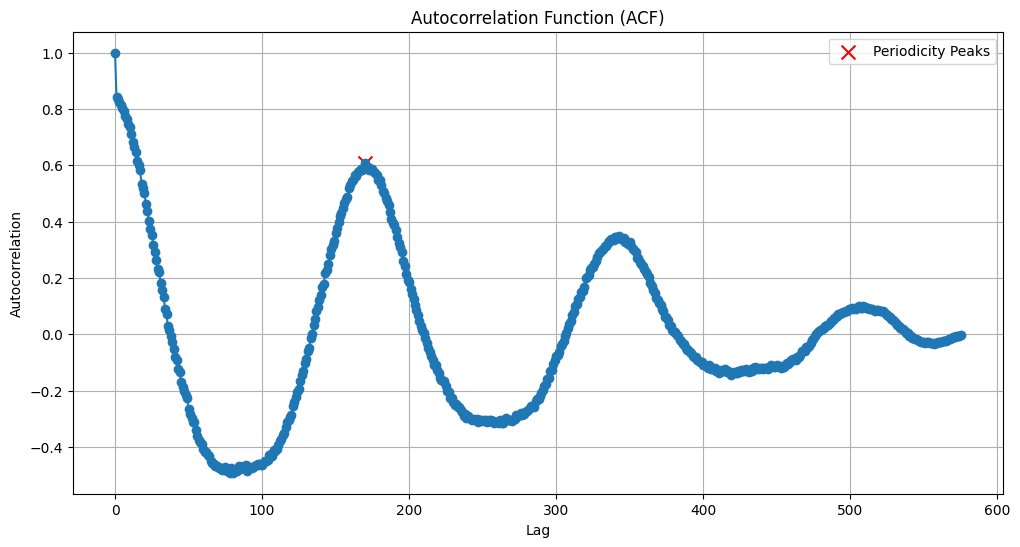

Identified periodicities: [11.858823529411763]
[11.65111656]


In [159]:
k = 46
autocorr = acf[k,0]
identify_frequencies(autocorr, args, 50)
print(frs[k])

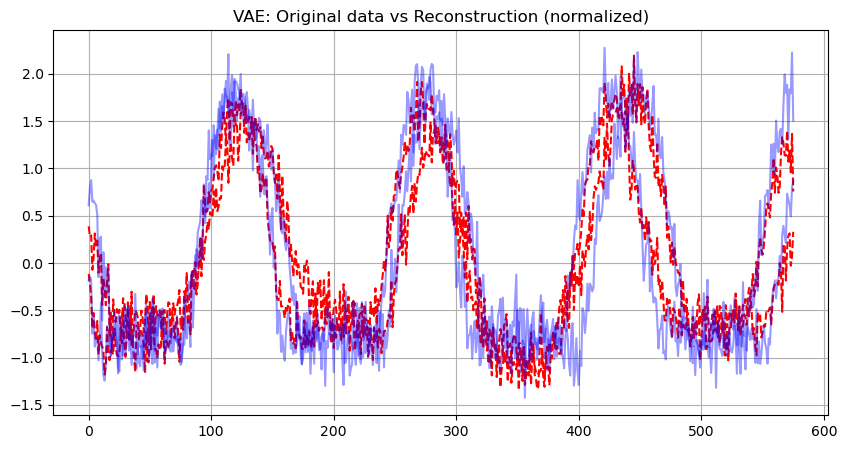

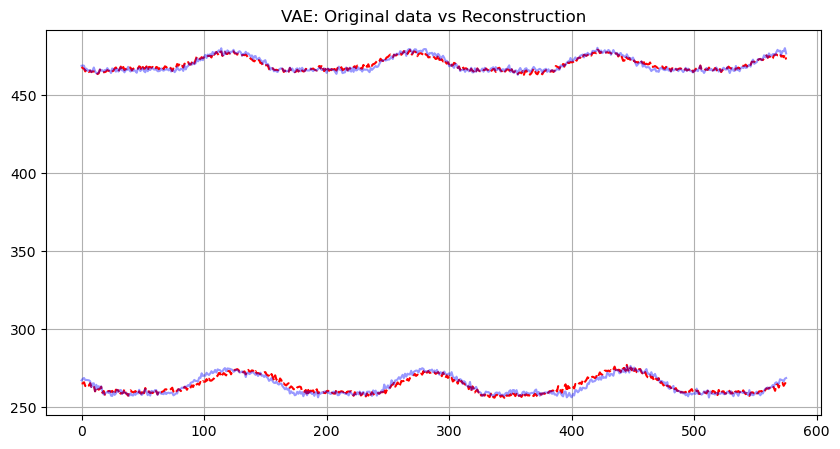

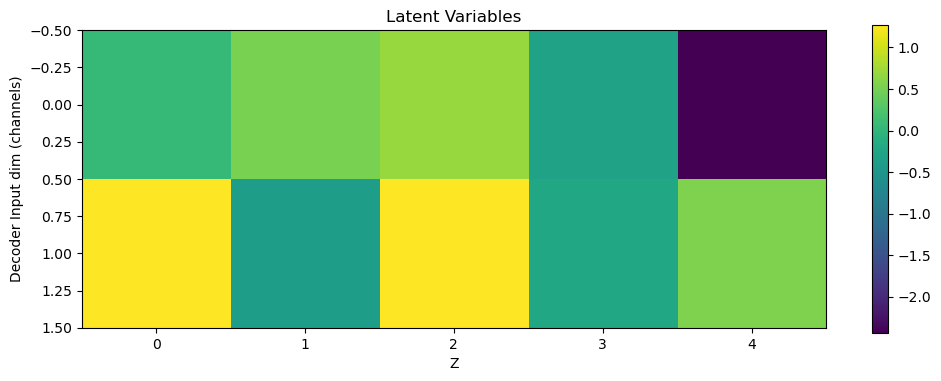

In [57]:
show_results(vae, train_data, args, sample=10, plot_latent=False)

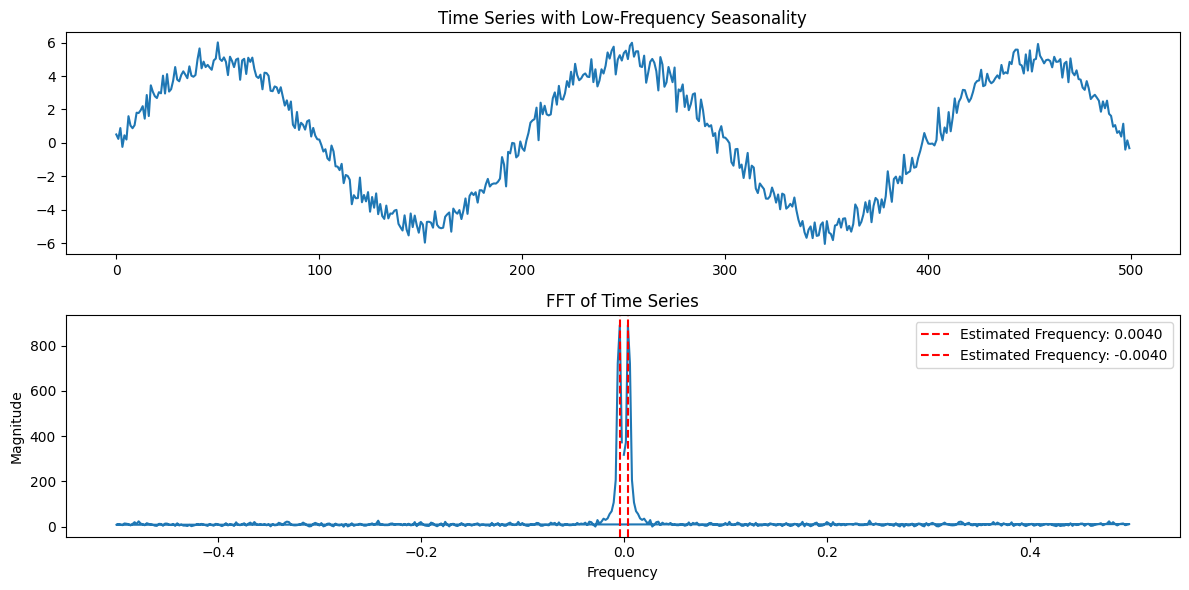

In [140]:
from scipy.signal import find_peaks

# Create a time series with low-frequency seasonality
n = 500
t = np.arange(n)
frequency = 0.005  # Low-frequency seasonality
seasonality = 5 * np.sin(2 * np.pi * frequency * t)
noise = np.random.normal(0, 0.5, n)
time_series = seasonality + noise

# Compute the FFT
fft_result = np.fft.fft(time_series)
sampling_frequency = 1  # Assuming unit sampling frequency
frequencies = np.fft.fftfreq(n, d=1 / sampling_frequency)

# Identify the peaks in the FFT magnitude plot
peaks, _ = find_peaks(np.abs(fft_result), 600)

# Extract corresponding frequencies
peak_frequencies = frequencies[peaks]

# Plot the time series and the estimated frequencies
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, time_series)
plt.title('Time Series with Low-Frequency Seasonality')

plt.subplot(2, 1, 2)
plt.plot(frequencies, np.abs(fft_result))
plt.title('FFT of Time Series')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')

# Plot the estimated frequencies
for freq in peak_frequencies:
    plt.axvline(x=freq, color='r', linestyle='--', label=f'Estimated Frequency: {freq:.4f}')
plt.legend()

plt.tight_layout()
plt.show()

(1009,)
[ 8  6  7 11 15]
[255.40695 298.44864 699.44946 662.7711  397.8458 ]
[112.  84.  98. 154. 210.]


array([ 9.40703251, 10.85850522, 10.41877301,  7.38420925])

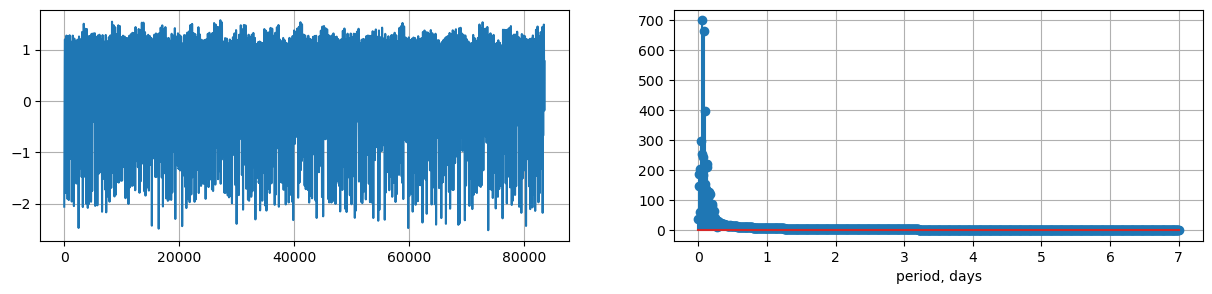

In [220]:
import scipy.fft as sf
import matplotlib.ticker as tck

days = 7
N = 288 * days
# N = denoised.shape[-1]
X = sf.rfft(denoised[0][:N]) #/ N
freqs = sf.rfftfreq(n=N, d=1/(days*2))

print(X.shape)
# Plot signal
fig, axes = plt.subplots(figsize=(15,3), ncols=2)
ax=axes[0]
ax.plot(denoised[0])
# ax.xaxis.set_major_locator(tck.MultipleLocator(50))
ax.grid()

# # Plot DFT
ax=axes[1]
extent = 288*7 -1#288*7#N
ax.set_xlabel('period, days')
# ax.stem(freqs[:extent], abs(X[:extent]))
ax.stem(freqs, abs(X))

# x_locator = MultipleLocator(base=288)
# ax.xaxis.set_major_locator(x_locator)
# ax.set_xticklabels([f'{a}' for a in range(days+1)])
# ticks = ax.get_xticks()
# ax.set_xticklabels([f'{a}' for a in range(1000)])
# ax.invert_xaxis()
ax.grid()
np.set_printoptions(suppress=True)

# print(np.argmax(X))
n=5
max_freq_ind = np.argpartition(np.abs(X), -n)[-n:]
print(max_freq_ind)
print(abs(X[max_freq_ind]))
print(freqs[max_freq_ind]*N)
frs

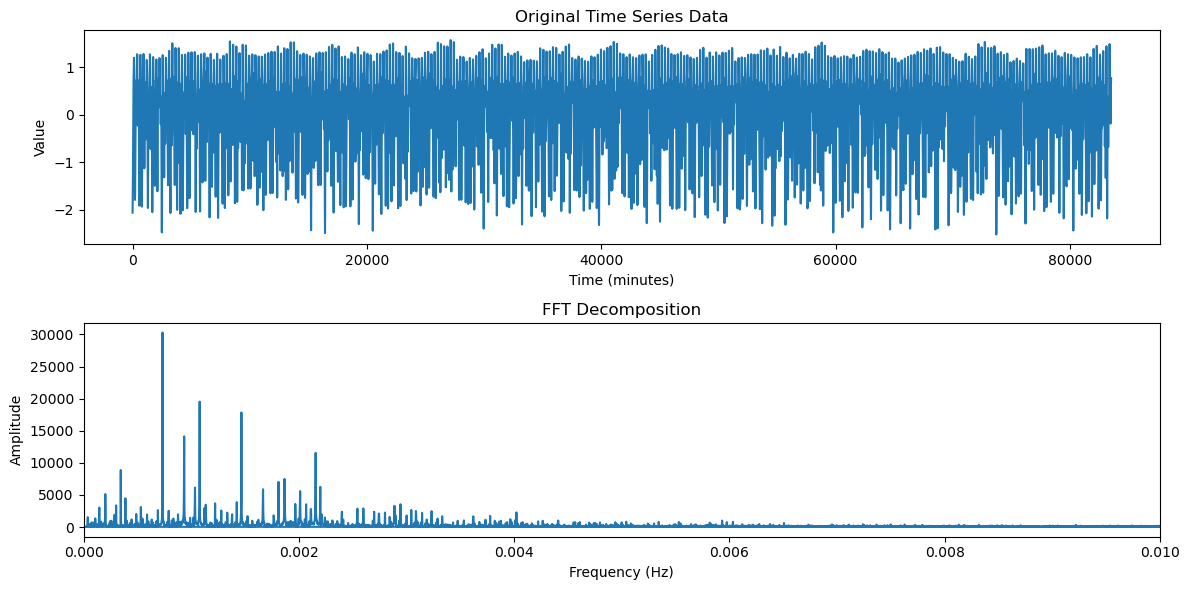

In [221]:
# Define your time series data with a 3-day seasonality
sampling_rate = 5  # 5 minutes between data points
num_points = denoised_orig.shape[0]  # Number of data points (assuming 5-minute intervals in a day)

# Create a time vector in minutes
time = np.arange(0, num_points)# * sampling_rate

# # Create a synthetic time series with a 3-day seasonality
# seasonality_freq = 1 / (3 * 24 * 60)  # Frequency in Hz (3 days in minutes)
# amplitude = 10  # Amplitude of the seasonality
# noise = np.random.normal(0, 1, num_points)  # Add some random noise
# data = amplitude * np.sin(2 * np.pi * seasonality_freq * time) + noise

# Perform FFT on the data
fft_result = np.fft.fft(Origin_norm[:,0].cpu())
frequencies = np.fft.fftfreq(denoised.shape[-1], d=sampling_rate)

# Plot the original data
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, denoised[0])
plt.title("Original Time Series Data")
plt.xlabel("Time (minutes)")
plt.ylabel("Value")

# Plot the FFT results
plt.subplot(2, 1, 2)
plt.plot(frequencies, np.abs(fft_result))
plt.title("FFT Decomposition")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.xlim(0, 0.01)  # Limit the x-axis to relevant frequencies

plt.tight_layout()
plt.show()


In [102]:
import tsfel
# Retrieves a pre-defined feature configuration file to extract all available features
cfg = tsfel.get_features_by_domain("statistical")

# Extract features
X = tsfel.time_series_features_extractor(cfg, Origin_vae[0].T, fs=1/(7*12*24), window_size=args.L, overlap=0)
# Y = tsfel.time_series_features_extractor(cfg, denoised)

*** Feature extraction started ***



*** Feature extraction finished ***


In [103]:
import pandas as pd
pd.options.display.max_rows = None
pd.set_option('display.float_format', lambda x: f'{x:.3f}')
# X.T.columns = ["val"]
# print(arr[15])
# X = pd.DataFrame(X.values.reshape(28, -1)) 
print(X.shape)
# for el in X:
#     val = X[el].item()
#     if (abs(arr[0]- val) <5).any():
#         print(X[el])
#         print(val)
#     print(X[el].item())
X.T

(1, 180)


,0
0_ECDF Percentile Count_0,115.000
0_ECDF Percentile Count_1,460.000
0_ECDF Percentile_0,363.054
0_ECDF Percentile_1,364.737
0_ECDF_0,0.002
0_ECDF_1,0.003
0_ECDF_2,0.005
0_ECDF_3,0.007
0_ECDF_4,0.009
0_ECDF_5,0.010
